# Multiclass models and weight analysis

## Exploration

Load the training dataset in a first step and inspect the data structure.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('agnews_train.csv')
display(data.head())
columns = list(data.columns)

,text,label,label_int,science_int,sports_int,world_int,business_int
0,"John Souza, a volunteer with the Boone County ...",Business,3,0,0,0,1
1,Spain needs only to beat an under-strength Fre...,Sports,1,0,1,0,0
2,"PANAMA CITY, Panama -- When the United States ...",World,2,0,0,1,0
3,"Gilbert Arenas, Jarvis Hayes and Anthony Peele...",Sports,1,0,1,0,0
4,"MEMPHIS, Tenn. -- Kobe Bryant had his worst sh...",Sports,1,0,1,0,0


In [15]:
data.describe()

,label_int,science_int,sports_int,world_int,business_int
count,109999.000000,109999.000000,109999.000000,109999.000000,109999.000000
mean,1.500341,0.249657,0.250384,0.249920,0.250039
std,1.117767,0.432816,0.433236,0.432969,0.433037
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000
75%,3.000000,0.000000,1.000000,0.000000,1.000000
max,3.000000,1.000000,1.000000,1.000000,1.000000


Compute an Analyzer function that tokenizes the words within the text and exludes fill words and punctuation.

In [4]:
sentence = data.text[0]
sentence.split()

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

def make_sklearn_analyzer():
    vect = CountVectorizer(stop_words=[])
    analyzer = vect.build_analyzer()
    return analyzer    # Tokenize the words within the text, excluding fill words and punctuation

sk_analyzer = make_sklearn_analyzer()
sk_analyzer(sentence)

for i in range(5):
   text = data.text[i]
   print('REVIEW', i)
   print('TEXT',text)
   print('WORDS', sk_analyzer(text))

REVIEW 0
TEXT John Souza, a volunteer with the Boone County chapter of the American Red Cross, is the second Columbia resident to join efforts to assist people who were affected by Tropical Storm Bonnie and Hurricane Charley.
WORDS ['john', 'souza', 'volunteer', 'with', 'the', 'boone', 'county', 'chapter', 'of', 'the', 'american', 'red', 'cross', 'is', 'the', 'second', 'columbia', 'resident', 'to', 'join', 'efforts', 'to', 'assist', 'people', 'who', 'were', 'affected', 'by', 'tropical', 'storm', 'bonnie', 'and', 'hurricane', 'charley']
REVIEW 1
TEXT Spain needs only to beat an under-strength French team to secure its place in the Davis Cup tennis final, while Britain looks to the experience of Tim Henman and Greg Rusedski in its World Group play-off with Austria this weekend.
WORDS ['spain', 'needs', 'only', 'to', 'beat', 'an', 'under', 'strength', 'french', 'team', 'to', 'secure', 'its', 'place', 'in', 'the', 'davis', 'cup', 'tennis', 'final', 'while', 'britain', 'looks', 'to', 'the',

Analyze the frequency and distribution of words within the dataset.

In [8]:
from collections import Counter

word_counts = Counter()
for text in data.text:
    word_counts.update(sk_analyzer(text))

print('Total Number of Words', len(word_counts.most_common()))

for w in 'company', 'Reuters', 'sport':
   print(w, word_counts[w])

word_counts.most_common(10)

Total Number of Words 58831
company 6648
Reuters 0
sport 305


[('the', 182263),
 ('to', 88925),
 ('of', 82101),
 ('in', 72156),
 ('and', 60998),
 ('on', 44011),
 ('for', 35113),
 ('39', 29262),
 ('that', 25467),
 ('with', 20823)]

<ipython-input-9-088771804f7a>:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


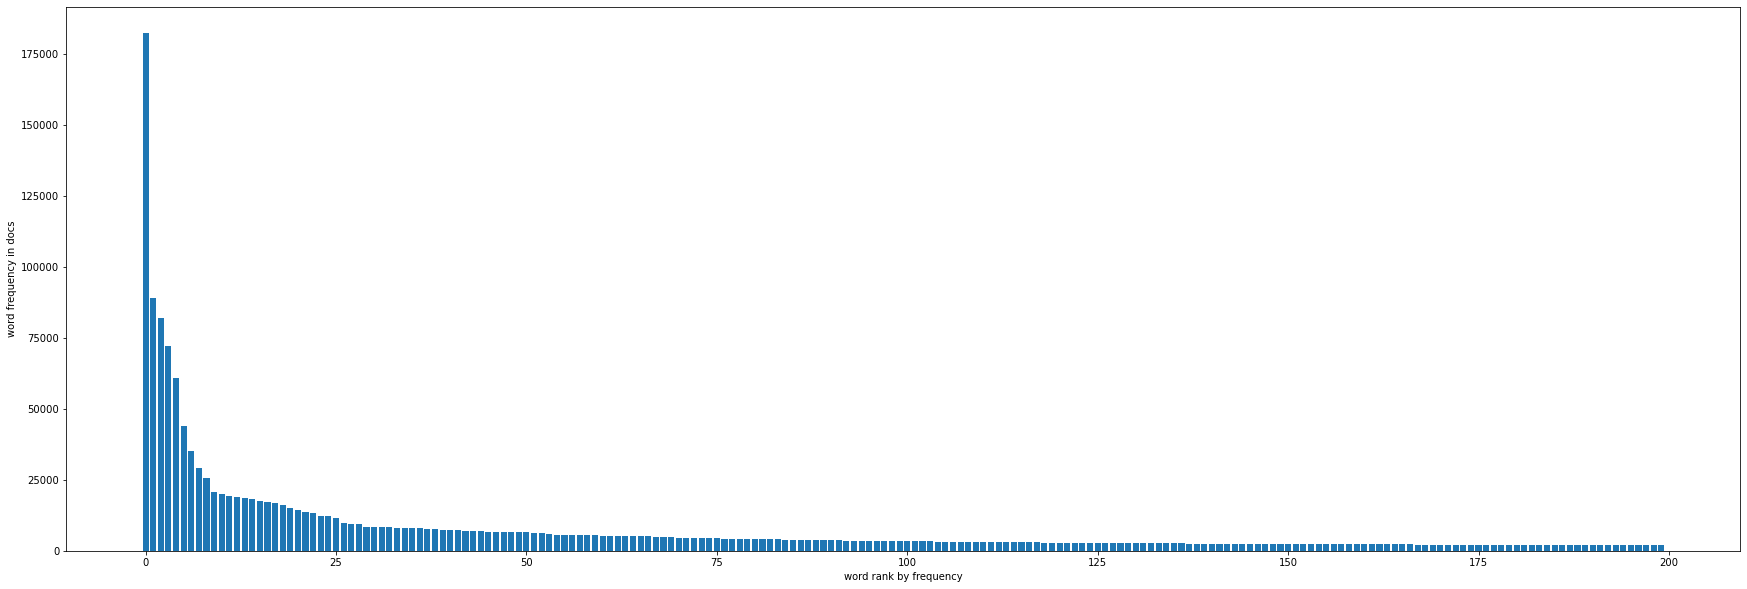

In [9]:
N = 200   # Plot frequency against rank of words by frequency
fig = plt.figure(figsize=(30,10))
plt.bar(range(N), [w[1] for w in word_counts.most_common(N)])
plt.xlabel('word rank by frequency')
plt.ylabel('word frequency in docs')
fig.show()

## Classification 

In [12]:
import sklearn.metrics
from sklearn.metrics import classification_report

from IPython.display import HTML, JSON
def display_df(df):
    return HTML(df.to_html())       

from qgrid import show_grid

In [16]:
# Balanced distribution of labels at ~25%
data_train = data
data_test = pd.read_csv('./agnews_test.csv')   # 8% test 
data_test.describe()   # Balanced distribution of labels at ~25%

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

### Simple classification with Naive Bayes multi-class categorization

In [21]:
def make_sklearn_naive_bayes():
    classifier = Pipeline([
        ('vect', CountVectorizer()),     # Extracts bag of words from text
        ('tfidf', TfidfTransformer()),   # Assigned word frequency
        ('clf', MultinomialNB()), ])     # ML algorithm learning word weights
    return classifier

dtrain_naivebayes = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', MultinomialNB()),
    ])
dtrain_naivebayes.fit(data_train.text, data_train.label_int)   
# Train Naive Bayes classifier on training dataset

dtest_naivebayes = dtrain_naivebayes.predict(data_test.text)

print(classification_report(data_test.label_int,
                            dtest_naivebayes))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87      2537
           1       0.95      0.98      0.96      2458
           2       0.90      0.89      0.89      2509
           3       0.86      0.86      0.86      2496

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



The Naive Bayes classifier yields an accuracy of 0.9 on the test set and precision values for the respective classes between 0.86 (Business) and 0.95 (Sports). Despite the dataset being balanced in the distribution of classes, this indicates strong differences in the model's performance in correctly predicting certain classes. Moreover, the Naive Bayes classifier yields a high recall metric for class 1 (Sports) as well, while the metric is significantly lower for the other 3 classes (between 0.86 and 0.89). This indicates that the model performs quite well in distinguishing most of the instances in this class, while it does less so on the other ones.   

### Simple classification with SGD Classifiers

In [22]:
def make_sklearn_sgd():
    classifier = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', SGDClassifier(loss='hinge', penalty='l2',
                              alpha=1e-3, random_state=42,
                              max_iter=5, tol=None))])
    return classifier

dtrain_sgd = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer(use_idf=True)),
        ('clf', SGDClassifier(loss='hinge', penalty='l2',
                              alpha=1e-6, random_state=42,   
                              max_iter=100, tol=None))])

dtrain_sgd.fit(data_train.text, data_train.label_int)

print(classification_report(data_test.label_int,
                            dtrain_sgd.predict(data_test.text))) 

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      2537
           1       0.96      0.97      0.96      2458
           2       0.91      0.88      0.89      2509
           3       0.86      0.88      0.87      2496

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



Changing the classifier has not really improved the performance of the model: while the overall accuracy remains at 0.9, precision and recall for each class have only slightly changed, but with no clear overall positive or negative direction.   

In [23]:
dtrain_sgd = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer(use_idf=True)),
        ('clf', SGDClassifier(loss='hinge', penalty='l2',
                              alpha=1e-3, random_state=42,   
                              max_iter=100, tol=None))])

dtrain_sgd.fit(data_train.text, data_train.label_int)

print(classification_report(data_test.label_int,
                            dtrain_sgd.predict(data_test.text))) 

              precision    recall  f1-score   support

           0       0.86      0.81      0.83      2537
           1       0.86      0.98      0.92      2458
           2       0.88      0.86      0.87      2509
           3       0.86      0.82      0.84      2496

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.86     10000
weighted avg       0.87      0.87      0.86     10000



One way to investigate what levers can improve model performance consists of finetuning the hyper-parameters of the model. For instance, we attempted to increase the alpha threshold to 1e-3 from 1e-6 (meaning that the model will be more regularized). However, this parameter change resulted in a performance drop of the model: overall accuracy decreased to 0.87, while precision and recall metrics almost consistently worsened across all 4 classes.

## Bag of n-grams classification with SGD Classifiers

As a next step, we transformed the underlying text elements and words within the dataset and tested several combinations of n-grams (unigram, bigram, trigram) as well as different alpha-thresholds in a cross-validated grid search to find the parameters that optimize the accuracy of our model with a stochastic gradient descent approach.

In [24]:
def make_sklearn_analyzer(n=1):
    vect = CountVectorizer(stop_words=[], ngram_range=(1,n))
    analyzer = vect.build_analyzer()
    return analyzer

unigram_analyzer = make_sklearn_analyzer(1)
bigram_analyzer = make_sklearn_analyzer(2)
trigram_analyzer = make_sklearn_analyzer(3)

from sklearn.model_selection import GridSearchCV

def crossvalidation_report_df(grid_cv):   
    cols = [c for c in grid_cv.cv_results_ if (c.startswith('param') or
                                              c in ['mean_test_score', 'rank_test_score'])] 
    return pd.DataFrame(grid_cv.cv_results_).sort_values(by='rank_test_score')[cols]

In [25]:
# Define SGD classifier and convenience function
sgd_grid_estimator = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer(use_idf=True)),
    ('clf', SGDClassifier(loss='hinge', penalty='l2', random_state=42, max_iter=100, tol=None))])

# Set grid search parameters
sgd_grid_parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (1,3)],
    'clf__alpha': (1e-3, 1e-6, 1e-9, 1e-12)}

# Set GridSearch function
sgd_grid= GridSearchCV(sgd_grid_estimator, sgd_grid_parameters, verbose=1)

In [35]:
# Run GridSearch on the train dataset
sgd_grid.fit(data_train.text, data_train.label_int)

crossvalidation_report_df(sgd_grid)
# Trigram, alpha 1e-06 has highest accuracy (0.912499)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 29.3min finished


,param_clf__alpha,param_vect__ngram_range,params,mean_test_score,rank_test_score
5,1e-06,"(1, 3)","{'clf__alpha': 1e-06, 'vect__ngram_range': (1,...",0.912499,1
4,1e-06,"(1, 2)","{'clf__alpha': 1e-06, 'vect__ngram_range': (1,...",0.910763,2
8,1e-09,"(1, 3)","{'clf__alpha': 1e-09, 'vect__ngram_range': (1,...",0.906281,3
11,1e-12,"(1, 3)","{'clf__alpha': 1e-12, 'vect__ngram_range': (1,...",0.905808,4
7,1e-09,"(1, 2)","{'clf__alpha': 1e-09, 'vect__ngram_range': (1,...",0.902363,5
10,1e-12,"(1, 2)","{'clf__alpha': 1e-12, 'vect__ngram_range': (1,...",0.901854,6
3,1e-06,"(1, 1)","{'clf__alpha': 1e-06, 'vect__ngram_range': (1,...",0.892299,7
2,0.001,"(1, 3)","{'clf__alpha': 0.001, 'vect__ngram_range': (1,...",0.870635,8
0,0.001,"(1, 1)","{'clf__alpha': 0.001, 'vect__ngram_range': (1,...",0.868053,9
1,0.001,"(1, 2)","{'clf__alpha': 0.001, 'vect__ngram_range': (1,...",0.867335,10


In [37]:
sgd_best = sgd_grid.best_estimator_ 
print('BEST PARAMS:', sgd_grid.best_params_)

print(classification_report(data_test.label_int,
                            sgd_best.predict(data_test.text)))

BEST PARAMS: {'clf__alpha': 1e-06, 'vect__ngram_range': (1, 3)}
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      2537
           1       0.95      0.98      0.97      2458
           2       0.91      0.90      0.91      2509
           3       0.89      0.87      0.88      2496

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



With the opimized model parameters (trigrams, with an alpha threshold of 1e-6), the model performance clearly improved: 
- Overall accuracy increased to 0.91 (0.9 for the original Naive Bayes and SGD classifiers)
- Recall and precision increased across all classes compared to the two original models (macro and weighted average inrceased from 0.9 to 0.91). 

However, even with the best parameters we could only achieve a minor performance improvement compared to our basic models. Thus, we decided to investigate other approaches, such as neural networks to investigate whether we can achieve even better results.

## Inspect Classifier Weights for Multi-Class Model

As a next step, we decided to look at what our models learned by inspecting the parameters and their weights as learned by the model. 

### Parameter weights of the original SGD classifier

In [32]:
def sort_feature_weights(sk_pipe, fkey='vect', wkey='clf'):
    F = sk_pipe[fkey].get_feature_names()
    W = sk_pipe[wkey].coef_[0]
    return sorted(zip(F, W), key=lambda fw: fw[1])
 
dtrain_sgd_weights = sort_feature_weights(dtrain_sgd)
n=10

dtrain_sgd_weights[:n]

[('fullquote', -0.8739376675650457),
 ('york', -0.7517832298862825),
 ('stocks', -0.6327144274440258),
 ('his', -0.600096179745413),
 ('yesterday', -0.4789500698850252),
 ('in', -0.45944857371331976),
 ('oil', -0.4495074933378113),
 ('he', -0.44799198813220076),
 ('season', -0.4381154232033775),
 ('aspx', -0.4369688337825228)]

In [33]:
dtrain_sgd_weights[-n:]

[('nasa', 1.3529981830453208),
 ('technology', 1.3954502513156175),
 ('users', 1.4353288785076748),
 ('web', 1.4679684224535572),
 ('computer', 1.5759304492791462),
 ('music', 1.6541195563470688),
 ('space', 2.290976803466792),
 ('internet', 2.339667153033667),
 ('software', 2.5017299948635388),
 ('microsoft', 2.6362945950936414)]

To begin with, we took a look at the parameters and weights learned by the original SGD classifier. 
Surprisingly, the words with the highest weights (e.g. 'microsoft', 'software', 'internet', 'space' etc.) could probably be associated with topics in the fields of science or business. However, our initial model had the lowest precision and recall scores for exactly these labels. On the other hand, while the model distinguished the 'Sports" label most successfully, none of the high-weight words is directly associated with sports.

Looking at the negatively-weighted parameters, we found more surprising results: most of the words seem to have less interpretative power than the positively-weight ones: e.g. 'his','yesterday','he','season' can be less easily categorized into one of the labels than 'microsoft' for instance.

### Parameter weights of the best-performing SGD classifier (Grid Search result)

In [63]:
sgd_best_weights = sort_feature_weights(sgd_best)
sgd_best_weights = sorted(sgd_best_weights, key=lambda fw: fw[1], reverse=True)

sgd_best_weights[:10]

[('space', 7.023450660165638),
 ('nasa', 6.1948301417173655),
 ('ap', 5.748732047383109),
 ('software', 5.647193887275042),
 ('internet', 5.588889764029919),
 ('scientists', 5.226673193357043),
 ('apple', 5.1071346204992505),
 ('washingtonpost com', 4.957600724582644),
 ('microsoft', 4.878306719863067),
 ('linux', 4.829559894782848)]

In [64]:
sgd_best_weights[-10:]

[('stocks', -2.7464637221065407),
 ('saturday', -2.799639645289625),
 ('sunday', -3.027339954953755),
 ('new york', -3.1925045363436158),
 ('york', -3.23534549658602),
 ('iraq', -3.2400012485346394),
 ('football', -3.2600094736425103),
 ('coach', -3.346162773986989),
 ('yesterday', -4.046763289988104),
 ('hellip', -4.2051911647795155)]

Similarly to the first model, the weight analysis shows that words such as 'space','nasa','software' are among the highest-weight words and give the model most interpretative power. However, this time the negatively-weight words can also be more clearly categorized into one of the labels ('football','iraq','coach'). Interestingly, we have a wider range of weights in our parameter summary: in the best model between -4.2 and 7.0, while the original model ranged from -0.9 to 2.6. It seems the model is able to more distinctly assign these words into one of the categories, which could explain its higher predictive power. 

### Parameter weights of the best-performing SGD classifier with bigram analysis

In [65]:
def ngram_order(f):
    return len(f.split())
[fw for fw in sgd_best_weights if ngram_order(fw[0])==2][:10]

[('washingtonpost com', 4.957600724582644),
 ('ap microsoft', 2.828741098727557),
 ('washington ap', 2.7064684100508947),
 ('pt organizations', 2.5687082222176727),
 ('reuters online', 2.4749183078056225),
 ('video game', 2.4697514302279995),
 ('ap google', 2.467626951216686),
 ('36 billion', 2.402926252974999),
 ('at corp', 2.3937935195251807),
 ('ap computer', 2.3580804723387847)]

In [66]:
[fw for fw in sgd_best_weights if len(fw[0].split())==2][-10:]

[('francisco reuters', -2.0551652509706706),
 ('york top', -2.100658178447378),
 ('hellip and', -2.2512636483476895),
 ('19 pm', -2.255474606398488),
 ('company 39', -2.313685301444235),
 ('39 largest', -2.335948190051315),
 ('canadian press', -2.444872268914245),
 ('inc the', -2.463560713028669),
 ('oracle 39', -2.533496095723256),
 ('new york', -3.1925045363436158)]

In the ngram weight summary, we can see that the most strongly weighted parameters are mostly those with a combination of news agency names ('washington ap','reuters online' etc.). Probably, this results from these bigrams' high frequency in the news articles and because they can be easily categorized to a class based on their focus in news reporting (e.g. Reuters with a focus on business news).

As a next step, we looked at some exemplary texts that contain some of these strongly positively and negatively weighted words and try to infer why the model assigned these weights. We did so by looking at the frequency of their occurence, the assigned labels we retrieved for the respective text as well as a subjective interpretation of the text.

In [92]:
# Analysis with a clearly allocatable word
(data[data['text'].str.contains ('space')])

,text,label,label_int,science_int,sports_int,world_int,business_int
37,SPACE.com - A new report released by an Americ...,Science,0,1,0,0,0
52,"MOJAVE, California -- SpaceShipOne made histor...",Science,0,1,0,0,0
88,"NASA, the American space agency responsible fo...",Science,0,1,0,0,0
122,A report commissioned by NASA says the space a...,Science,0,1,0,0,0
189,"PASADENA, Calif. -- Northrop Grumman Space Tec...",Science,0,1,0,0,0
...,...,...,...,...,...,...,...
109615,"Buzz Aldrin, the second man to walk on the moo...",Science,0,1,0,0,0
109678,A Russian-US crew returned to Earth from the i...,Science,0,1,0,0,0
109694,"SPACE.com - MOJAVE, CALIFORNIA - Human \ flig...",Science,0,1,0,0,0
109827,SALT LAKE CITY -- For Los Alamos physicist Rog...,Science,0,1,0,0,0


In [88]:
(data[data['text'].str.contains ('space')]).describe()

,label_int,science_int,sports_int,world_int,business_int
count,1575.000000,1575.000000,1575.000000,1575.000000,1575.000000
mean,0.289524,0.889524,0.002540,0.036825,0.071111
std,0.840515,0.313582,0.050347,0.188393,0.257092
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,0.000000,0.000000
max,3.000000,1.000000,1.000000,1.000000,1.000000


In [84]:
data[data['text'].str.contains ('space')]['text'][52]

'MOJAVE, California -- SpaceShipOne made history Monday and triumphed in the international Ansari X Prize race to launch the first privately built spacecraft.'

In [86]:
data[data['text'].str.contains ('space')]['text'][109678]

'A Russian-US crew returned to Earth from the international space station Sunday in a pinpoint landing on the Kazakhstan steppe, and NASA #39;s chief said the United States '

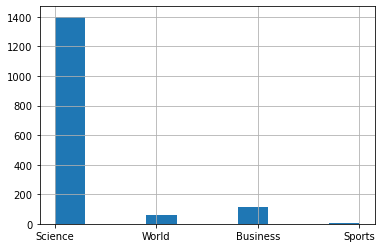

In [98]:
yesterday = (data[data['text'].str.contains ('space')])['label']
yesterday.hist()

In [91]:
# Analysis with a less clearly allocatable word
(data[data['text'].str.contains ('yesterday')])

,text,label,label_int,science_int,sports_int,world_int,business_int
144,Luke Donald kept his cool in the Swiss mountai...,Sports,1,0,1,0,0
186,Banking group HBoS has been given access to Ab...,Business,3,0,0,0,1
200,"JUST yesterday, it looked as though West Indie...",Sports,1,0,1,0,0
203,names Tiger Woods turned in his most complete ...,Sports,1,0,1,0,0
224,A sabotage attack on a cluster of about 20 oil...,World,2,0,0,1,0
...,...,...,...,...,...,...,...
109846,Computer Associates International yesterday re...,Science,0,1,0,0,0
109863,Arm Holdings shares slumped 18pc yesterday aft...,Business,3,0,0,0,1
109867,Army commanders ordered a Patriot missile batt...,World,2,0,0,1,0
109940,Jeremy Shockey yesterday reiterated his commen...,Sports,1,0,1,0,0


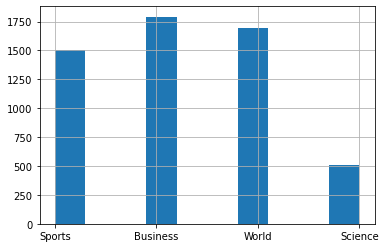

In [96]:
yesterday = (data[data['text'].str.contains ('yesterday')])['label']
yesterday.hist()

In [90]:
(data[data['text'].str.contains ('yesterday')])['text'][109940]

'Jeremy Shockey yesterday reiterated his comments from Wednesday about his frustration with his role but denied he was insinuating that he is unhappy with how Giants coach Tom Coughlin is using him.'

We can clearly see that the model allocates a strong weight to words such as 'space' as it almost exclusively appears in texts that belong to the label 'science' (supported by around 1,400 instances). More open words such as 'yesterday' on the other hand, have a higher distribution among the different labels and thus have less predictive power, leading to a lower / negative score.

### Predicting the class of an exemplary sentence

In [51]:
sgd_best.decision_function(['The football club made a great game and won against the other team'])

array([[-1.57960466,  2.99630365, -2.2812262 , -2.52231613]])

In [53]:
sgd_best.decision_function(['The scientists discovered the new vaccine after after years of research and experiments'])

array([[ 1.41651179, -1.86746694, -0.93583407, -1.46080558]])

In [107]:
sgd_best.predict(['The company made record profits in this fiscal year'])

array([3])

With multi-class predictions, the model categorizes the text to the respective labels by identifying the category with the highest weight. For instance: the 2nd test text can be clearly allocated to the 'Science' category, and correspondingly the weight for this label in the decision array is the highest (1.42 for label 0 = Science). Internally, the model allocates the weights to each of the classes and predicts the class with the heighest weight in this more complex multi-class setup (compared to the easier positive-negative binary classification task).

### Exemplary prediction score breakdown
Considering the bias of each prediction as well as the composite weights and scores of each word and their combinations within the text example.

In [67]:
# Compute the prediction score of a text by breaking it down into the individual values, 
# weights and scores of each single word and n-grams of the text.

def prediction_score_breakdown(sk_model, text):

    X = [text]
    for step_name, model in sk_model.steps[:-1]:
        X = model.transform(X)
    nzrows, nzcolumns = X.nonzero()
    
    F = sk_model.steps[0][1].get_feature_names()
    W = sk_model.steps[-1][1].coef_[0]
    bias = sk_model.steps[-1][1].intercept_[0]
    total_score = bias
    print('prediction_score={:.3f}   bias={}'.format(total_score, bias))
    
    for i,j in zip(nzrows, nzcolumns):
        f = F[j]
        v = X[i,j]
        w = W[j]
        s = w*v
        total_score += s
        print('prediction_score={:.3f}fdim={:5d}, fword="{:s}", value={:.4f},weight={:.4f}, score={:.4f}'.format(total_score, j, f, v, w, s))
    
    return total_score

In [60]:
prediction_score_breakdown(sgd_best, 'The scientists discovered the new vaccine after years of research and experiments')

prediction_score=-0.404   bias=-0.40382827216515377
prediction_score=-0.376fdim=2812192, fword="years of research", value=0.3316,weight=0.0838, score=0.0278
prediction_score=-0.377fdim=2812038, fword="years of", value=0.1886,weight=-0.0043, score=-0.0008
prediction_score=-0.375fdim=2810565, fword="years", value=0.1207,weight=0.0172, score=0.0021
prediction_score=-0.308fdim=2643819, fword="vaccine", value=0.2172,weight=0.3075, score=0.0668
prediction_score=-0.405fdim=2426050, fword="the scientists", value=0.2817,weight=-0.3440, score=-0.0969
prediction_score=-0.423fdim=2410815, fword="the new", value=0.1380,weight=-0.1294, score=-0.0179
prediction_score=-0.502fdim=2362622, fword="the", value=0.0678,weight=-1.1627, score=-0.0788
prediction_score=-0.495fdim=2094570, fword="scientists discovered", value=0.3316,weight=0.0208, score=0.0069
prediction_score=0.337fdim=2094361, fword="scientists", value=0.1592,weight=5.2267, score=0.8322
prediction_score=0.393fdim=2007951, fword="research and",

1.4165117923840553